In [1]:
import torch
from syncode import SyncodeLogitsProcessor
from syncode import Grammar
from transformers import AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt
device = 'cuda'
model_name = "microsoft/phi-2"
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16).eval().to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## ASAp Implementation
ASAp works by performing ancestral sampling n times and keeping an upper bound of the expected future grammaticality of each prefix which is updated every sample. Note: this implementation does not work for input batches.

In [2]:
from copy import deepcopy

class EFGTreeNode():
    """ Store our EFG map as a tree. Each node corresponds to a single token at the end of the prefix formed by the parent nodes. """
    def __init__(self, parent, key):
        # vals is the EFG of each continuation from the current node, initialized to one
        self.vals = torch.ones(len(tokenizer))
        # children points to the node of each continuation from the current node
        self.children = [None] * (len(tokenizer))
        # unseen is true if this node has been chosen as a continuation before
        self.unseen = True
        # parent points to the parent node  
        self.parent = parent
        # score tracks the EFG of this node
        self.efg = 1
        # key tracks the token of this node
        self.key = key
        
    def goto_next(self, next_key):
        # Goes to the next node or creates it if it doesn't exist
        if self.children[next_key] is None:
            self.children[next_key] = EFGTreeNode(self, next_key)
        return self.children[next_key]

    def set_efg(self, new_efg):
        # Updates this node and the parent node with the new score
        self.efg = new_efg
        self.parent.vals[self.key] = new_efg

    def print_sequence_efg(self, sequence):
        curr = self
        for i in sequence:
            curr = curr.children[i]
            print(f"token: `{i}`, str: `{tokenizer.decode(i)}`, efg: {curr.efg}")
            
    def get_seen_sequences(self):
        seq = []
        def rec(curr, strings):
            for string in strings:
                string.append(curr.key)
            next_c = []
            for child in curr.children:
                if child is not None:
                    next_c.append(child)
            if next_c:
                for child in next_c:
                    rec(child, deepcopy(strings))
            else:
                nonlocal seq
                seq += strings
        rec(self, [[]])
        return seq

In [3]:
from transformers import LogitsProcessor, PreTrainedTokenizer
import syncode.common as common
from torch.nn.functional import softmax
import numpy as np
DEBUG=False
class ASApSyncodeLogitsProcessor(SyncodeLogitsProcessor):
    """
    This class is used to filter the logits of the model to only allow syntactically valid tokens for Python. 
    This class augments SyncodeLogitsProcessor with the addition of an EFG_map, which maps a prefix to its
    expected future grammaticality. 
    The logits are multiplied by the EFG of their corresponding words.

    Args:
        grammar (str): The grammar to use for parsing e.g. "python".
        tokenizer (PreTrainedTokenizer): The tokenizer to use for decoding.
        logger (common.Logger): The logger to use for logging.
        use_cache (bool, optional): Whether to use the cache. Defaults to True.
        parse_output_only (bool, optional): Whether to parse the prompt. Defaults to False.
        dev_mode (bool, optional): Whether to run in development mode. Defaults to False.
    """

    def reset(self, prompt: str, EFG_root):
        """
        Resets the decoder state on every new prompt.
        EFG_root: Root of the EFG tree
        """
        super().reset(prompt)
        self.no_accept_tokens_err_count = 0
        self.EFG_curr = EFG_root

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor) -> torch.FloatTensor:    
        # start_from is used for choosing where the parsing should start
        partial_codes = self._get_partial_codes(input_ids)
        # update curr
        self.EFG_curr = self.EFG_curr.goto_next(input_ids[0,-1])

        for idx, partial_code in enumerate(partial_codes):
            ## Parsing
            try: # returns the accept sequences that are currently accepted.
                r = self.inc_parser.get_acceptable_next_terminals(partial_code)
            except Exception as e:
                if self.dev_mode == True:
                    raise e
                self.logger.log(f"Exception while parsing:\n {e}")
                continue  # Skip altering the scores for this batch

            self.update_valid_state(input_ids, idx, r)
        
            accept_mask = self.dfa_mask_store.get_accept_mask(r, logger=self.logger)

            if DEBUG: 
                self._log_current_status(partial_code, r)
                greedy_token = self.tokenizer.decode(scores[idx].argmax(dim=-1)) 

            if torch.sum(accept_mask) != 0: # If there are acceptable tokens for the current partial code
                if len(scores[idx]) != len(accept_mask):
                    # Pad accept_mask with 0 values. Since scores[i] may be longer than tokenizer vocab size, we need to pad accept_mask with 0 values
                    accept_mask = torch.cat((accept_mask, torch.zeros(len(scores[idx]) - len(accept_mask), dtype=torch.bool)))
                
                if self.EFG_curr.unseen == True:
                    # If we have not visited this continuation before, set the vals for this node to the accept mask
                    self.EFG_curr.vals = accept_mask.float()
                    self.EFG_curr.unseen = False
                    
                scores[idx] = scores[idx].masked_fill(~accept_mask.to(scores.device), -float("inf"))
                # Multiply probabilities by EFG_map                
                EFG_vals = torch.log(torch.cat((self.EFG_curr.vals, torch.ones(len(scores[idx]) - len(self.EFG_curr.vals)))).to(scores.device))
                scores[idx] += EFG_vals
                
            else: # Otherwise, report the error and mask no tokens
                self.logger.log('No acceptable tokens for the current partial code!')
                self._log_current_status(partial_code, r)
                self.no_accept_tokens_err_count += 1
                # assert(False)

            # For debugging - remove later
            if DEBUG: self._debug_greedy(scores, idx, partial_code, r, greedy_token)

        return scores

In [4]:
from pprint import pprint
from tqdm.notebook import tqdm
import torch.nn.functional as F

def visualize_neglogprobs(model, input_ids):
    input_ids = input_ids.unsqueeze(0)
    outputs = model(input_ids)
    probs = torch.log_softmax(outputs.logits, dim =-1)
    probs = -probs[:, :-1, :]
    input_ids = input_ids[:, 1:]
    gen_probs = torch.gather(probs, 2, input_ids[:, :, None]).squeeze(-1)
    batch = []
    for input_sentence, input_probs in zip(input_ids, gen_probs):
        text_sequence = []
        for token, p in zip(input_sentence, input_probs):
            if token not in tokenizer.all_special_ids:
                text_sequence.append((tokenizer.decode(token), p.item()))
        batch.append(text_sequence)
    return batch

def get_neglogprobs(model, input_ids):
    # The outputs returned by model(input_ids) is an array of token probabilties. The ith array in the output corresponds to the probability of the tokens after the ith input token. 
    input_ids = input_ids.unsqueeze(0)
    outputs = model(input_ids)
    probs = torch.log_softmax(outputs.logits, dim =-1)
    probs = -probs[:, :-1, :]
    input_ids = input_ids[:, 1:]
    gen_probs = torch.gather(probs, 2, input_ids[:, :, None]).squeeze((0, -1))
    return F.pad(gen_probs, pad=(1,0))

def KL_divergence(samples, input_ids, EFG_tree, add_out = False):
    # assumes each sample has been seen by the EFG tree
    KL_div = 0
    # Compute sum of Q_est(x) * ln(Q_est(x)/P(x))
    with torch.no_grad():
        for sample in samples:
            sample = sample["output_ids"]
            Q_est = torch.tensor(0.0, device=device)
            P = torch.tensor(0.0, device=device)
            efg_node = EFG_tree.goto_next(sample[len(input_ids)-1])
            raw_probs = model(sample.unsqueeze(0))
            raw_probs = torch.softmax(raw_probs.logits, dim=-1).squeeze(0)
            for i in range(len(input_ids), len(sample)-1):
                # See eqn 5
                efg_node = efg_node.children[sample[i]]
                Q_est += torch.log((raw_probs[i-1, sample[i]]) * efg_node.efg)
                Q_est -= torch.log(torch.sum(raw_probs[i-1, :len(efg_node.parent.vals)] * efg_node.parent.vals.to(device)))
                P += torch.log(raw_probs[i-1, sample[i]])
                # if add_out:
                #     print("i: ", i)
                #     print("Q_est top", torch.log((raw_probs[i-1, sample[i]]) * efg_node.efg))
                #     print("Q_est bot", torch.log(torch.sum(raw_probs[i-1, :len(efg_node.parent.vals)] * efg_node.parent.vals.to(device))))
                #     print("P:", torch.log(raw_probs[i-1, sample[i]]))
                if (torch.any(torch.isnan(Q_est))):
                    print(f"Q_est is nan - sample: {sample}")
                    break
            if (not torch.any(torch.isnan(Q_est))):
                KL_div += torch.exp(Q_est) * (Q_est - P)
            if add_out:
                print("P: ", P)
                print("Q_est: ", Q_est)
                print("log: ", Q_est-P)
                print("KL_div:", KL_div)
        return KL_div
        
def KL_divergence_GCD(samples, input_ids, EFG_tree, add_out = False):
    # assumes each sample has been seen by the EFG tree
    KL_div = 0
    # Compute sum of Q_est(x) * ln(Q_est(x)/P(x))
    with torch.no_grad():
        for sample in samples:
            sample = sample["output_ids"]
            Q_est = torch.tensor(0.0, device=device)
            P = torch.tensor(0.0, device=device)
            efg_node = EFG_tree.goto_next(sample[len(input_ids)-1])
            raw_probs = model(sample.unsqueeze(0))
            raw_probs = torch.softmax(raw_probs.logits, dim=-1).squeeze(0)
            for i in range(len(input_ids), len(sample)-1):
                # See eqn 5
                efg_node = efg_node.children[sample[i]]
                efg = efg_node.efg > 0
                Q_est += torch.log((raw_probs[i-1, sample[i]]) * efg)
                accept_mask = torch.where(efg_node.parent.vals > 0, torch.ones(efg_node.parent.vals.shape), torch.zeros(efg_node.parent.vals.shape))
                Q_est -= torch.log(torch.sum(raw_probs[i-1, :len(efg_node.parent.vals)] * accept_mask.to(device)))
                P += torch.log(raw_probs[i-1, sample[i]])
                # if add_out:
                #     print("i: ", i)
                #     print("Q_est top", torch.log((raw_probs[i-1, sample[i]]) * efg_node.efg))
                #     print("Q_est bot", torch.log(torch.sum(raw_probs[i-1, :len(efg_node.parent.vals)] * efg_node.parent.vals.to(device))))
                #     print("P:", torch.log(raw_probs[i-1, sample[i]]))
                if (torch.any(torch.isnan(Q_est))):
                    print(f"Q_est is nan - sample: {sample}")
                    break
            if (not torch.any(torch.isnan(Q_est))):
                KL_div += torch.exp(Q_est) * (Q_est - P)
            if add_out:
                print("P: ", P)
                print("Q_est: ", Q_est)
                print("log: ", Q_est-P)
                print("KL_div:", KL_div)
        return KL_div
        
def generate_KL_div_samples(model, prompt, tokenizer, syncode_logits_processor: ASApSyncodeLogitsProcessor, max_length=100, num_KL_div_samples=20):
    EFG_tree = EFGTreeNode(None, None)
    inputs = tokenizer(prompt, return_tensors='pt').input_ids.to(device)
    samples = []
    print("Generating KL_div samples..")
    with torch.no_grad():
        for sample in tqdm(range(num_KL_div_samples)):
            success = False
            while not success:
                try:
                    syncode_logits_processor.reset(prompt, EFG_tree)
                    output = model.generate(
                      inputs,
                      max_length=max_length, 
                      num_return_sequences=1, 
                      pad_token_id=tokenizer.eos_token_id, 
                      logits_processor=[syncode_logits_processor],
                      output_scores=True,
                      return_dict_in_generate=True,
                      do_sample=True,
                    )
                    if syncode_logits_processor.no_accept_tokens_err_count > 0:
                        print(f"No accept tokens err count: {syncode_logits_processor.no_accept_tokens_err_count}") 
                    success = True
                except Exception as e:
                    print("Error: ", e) 
    
            for output_seq in output.sequences:
                samples.append({"output_ids": output_seq})

    kl_div = KL_divergence(samples, inputs[0], EFG_tree)
    return samples, EFG_tree, kl_div

def ASAp(model, prompt, tokenizer, syncode_logits_processor: ASApSyncodeLogitsProcessor, max_length=100, num_samples=100, add_out = False, show_KL_div = False, KL_div_samples = [],EFG_tree = None):
    if EFG_tree is None:
        EFG_tree = EFGTreeNode(None, None)
        
    inputs = tokenizer(prompt, return_tensors='pt').input_ids.to(device)
    samples = []
    with torch.no_grad():
        for sample in tqdm(range(num_samples)):
            success = False
            while not success:
                try:
                    syncode_logits_processor.reset(prompt, EFG_tree)
                    output = model.generate(
                      inputs,
                      max_length=max_length, 
                      num_return_sequences=1, 
                      pad_token_id=tokenizer.eos_token_id, 
                      logits_processor=[syncode_logits_processor],
                      output_scores=True,
                      return_dict_in_generate=True,
                      do_sample=True,
                    )
                    if syncode_logits_processor.no_accept_tokens_err_count > 0:
                        print(f"No accept tokens err count: {syncode_logits_processor.no_accept_tokens_err_count}") 
                    success = True
                except Exception as e:
                    print("Error: ", e) 
            # Update EFG map
    
            for output_seq in output.sequences:
                raw_probs = model(output_seq.unsqueeze(0))
                raw_probs = torch.softmax(raw_probs.logits, dim=-1).squeeze(0)
                samples.append({"output_ids": output_seq})
                EFG_node_wi = EFG_tree
                if add_out:
                    print("seen sequences:", EFG_tree.get_seen_sequences())
                    print("output_seq: ", output_seq)
                    EFG_tree.print_sequence_efg(output_seq[len(inputs[0])-1:-1])
                    print("neg_log_probs: ", visualize_neglogprobs(model, output_seq))
    
                # Start at one node before the end because the end token is not seen by logits processor (should be EOF anyway and have a efg of 1)
                # Note that we start at root and EFG tree stores the last token in the input.
                for i in output_seq[len(inputs[0])-1:-1]: 
                    EFG_node_wi = EFG_node_wi.children[i]
    
                # Update the EFG node corresponding to wi. Iterate starting from the last node before the end token. End at the node corresponding to the last token in the input. 
                for i in range(len(output_seq) - 2, inputs.size(1) - 2, -1):
                    # EFG_node_wi points to EFG node of w[1:i]
                    assert(EFG_node_wi.key == output_seq[i])
                    new_efg_wi = torch.sum(raw_probs[i, :len(EFG_node_wi.vals)].to("cpu") * EFG_node_wi.vals)
                    EFG_node_wi.set_efg(new_efg_wi)
                    EFG_node_wi = EFG_node_wi.parent
    
                assert(EFG_node_wi == EFG_tree)
                if add_out:
                    print("after update:") 
                    EFG_tree.print_sequence_efg(output_seq[len(inputs[0]) - 1:-1])
                if show_KL_div:
                    if KL_div_samples:
                        KL_div_samples.append(samples[-1])
                        samples[-1]["KL_div_aft_sample"] = KL_divergence(KL_div_samples, inputs[0], EFG_tree)
                    else:
                        samples[-1]["KL_div_aft_sample"] = KL_divergence(samples, inputs[0], EFG_tree)
                    print(f"KL_div after sample {sample}: {samples[-1]['KL_div_aft_sample']}")

    return samples, EFG_tree

## ASAp-Beam Implementation
Variation on ASAp, where a single beam search round is conducted to estimate the EFGs before returning an output with ancestral sampling.

In [5]:
class ASApBeamSyncodeLogitsProcessor(SyncodeLogitsProcessor):
    """
    This class is used to filter the logits of the model to only allow syntactically valid tokens for Python. 
    This class augments SyncodeLogitsProcessor with the addition of an EFG_map, which maps a prefix to its
    expected future grammaticality. 
    The logits are multiplied by the EFG of their corresponding words.
    ASApBeam differs from the regular version because it walks the EFG tree each time it is called.

    Args:
        grammar (str): The grammar to use for parsing e.g. "python".
        tokenizer (PreTrainedTokenizer): The tokenizer to use for decoding.
        logger (common.Logger): The logger to use for logging.
        use_cache (bool, optional): Whether to use the cache. Defaults to True.
        parse_output_only (bool, optional): Whether to parse the prompt. Defaults to False.
        dev_mode (bool, optional): Whether to run in development mode. Defaults to False.
    """

    def reset(self, prompt: str, EFG_root):
        """
        Resets the decoder state on every new prompt.
        EFG_root: Root of the EFG tree
        """
        super().reset(prompt)
        self.prompt_length = len(tokenizer(prompt, return_tensors='pt').input_ids[0]) - 1
        self.no_accept_tokens_err_count = 0
        self.EFG_root = EFG_root

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor) -> torch.FloatTensor:    
        # start_from is used for choosing where the parsing should start
        partial_codes = self._get_partial_codes(input_ids)

        for idx, partial_code in enumerate(partial_codes):
            ## Parsing
            try: # returns the accept sequences that are currently accepted.
                r = self.inc_parser.get_acceptable_next_terminals(partial_code)
            except Exception as e:
                if self.dev_mode == True:
                    raise e
                self.logger.log(f"Exception while parsing:\n {e}")
                continue  # Skip altering the scores for this batch

            self.update_valid_state(input_ids, idx, r)

            # Walk EFG
            EFG_curr = self.EFG_root
            for tok in input_ids[idx,self.prompt_length:]:
                EFG_curr = EFG_curr.goto_next(tok)
        
            accept_mask = self.dfa_mask_store.get_accept_mask(r, logger=self.logger)

            if DEBUG: 
                self._log_current_status(partial_code, r)
                greedy_token = self.tokenizer.decode(scores[idx].argmax(dim=-1)) 

            if torch.sum(accept_mask) != 0: # If there are acceptable tokens for the current partial code
                if len(scores[idx]) != len(accept_mask):
                    # Pad accept_mask with 0 values. Since scores[i] may be longer than tokenizer vocab size, we need to pad accept_mask with 0 values
                    accept_mask = torch.cat((accept_mask, torch.zeros(len(scores[idx]) - len(accept_mask), dtype=torch.bool)))
                
                if EFG_curr.unseen == True:
                    # If we have not visited this continuation before, set the vals for this node to the accept mask
                    EFG_curr.vals = accept_mask.float()
                    EFG_curr.unseen = False
                    
                scores[idx] = scores[idx].masked_fill(~accept_mask.to(scores.device), -float("inf"))
                # Multiply probabilities by EFG_map                
                EFG_vals = torch.log(torch.cat((EFG_curr.vals, torch.ones(len(scores[idx]) - len(EFG_curr.vals)))).to(scores.device))
                scores[idx] += EFG_vals
                
            else: # Otherwise, report the error and mask no tokens
                self.logger.log('No acceptable tokens for the current partial code!')
                self._log_current_status(partial_code, r)
                self.no_accept_tokens_err_count += 1
                # assert(False)

            # For debugging - remove later
            if DEBUG: self._debug_greedy(scores, idx, partial_code, r, greedy_token)

        return scores
        

In [6]:
def ASApBeam(model, prompt, tokenizer, syncode_logits_processor: ASApBeamSyncodeLogitsProcessor, max_length=100, num_beams=4, add_out = False, EFG_tree = None):
    if EFG_tree is None:
        EFG_tree = EFGTreeNode(None, None)
        
    inputs = tokenizer(prompt, return_tensors='pt').input_ids.to(device)
    with torch.no_grad():
        success = False
        while not success:
            try:
                syncode_logits_processor.reset(prompt, EFG_tree)
                output = model.generate(
                  inputs,
                  max_length=max_length, 
                  num_return_sequences=1, 
                  pad_token_id=tokenizer.eos_token_id, 
                  logits_processor=[syncode_logits_processor],
                  output_scores=True,
                  return_dict_in_generate=True,
                  early_stopping=True,
                  num_beams=num_beams,
                )
                if syncode_logits_processor.no_accept_tokens_err_count > 0:
                    print(f"No accept tokens err count: {syncode_logits_processor.no_accept_tokens_err_count}") 
                success = True
            except Exception as e:
                print("Error: ", e) 
        # Update EFG map
        for output_seq in output.sequences:
            if add_out:
                print("seen sequences:")
                pprint(EFG_tree.get_seen_sequences())
                print("output_seq: ", output_seq)
                EFG_tree.print_sequence_efg(output_seq[len(inputs[0])-1:-1])
                print("neg_log_probs: ", visualize_neglogprobs(model, output_seq))
            # Get the seen sequences by the EFG tree, and update the EFG using each seen sequence.
            seen_sequences = EFG_tree.get_seen_sequences()
            for sequence in seen_sequences:
                output_seq = torch.tensor(sequence[2:], device=device)
                output_seq = torch.cat((inputs[0], output_seq)) 
                raw_probs = model(output_seq.unsqueeze(0))
                raw_probs = torch.softmax(raw_probs.logits, dim=-1).squeeze(0)
                # Update step
                # # Start at one node before the end because the end token is not seen by logits processor (should be EOF anyway and have a efg of 1)
                # # Note that we start at root and EFG tree stores the last token in the input.
                EFG_node_wi = EFG_tree
                for i in output_seq[len(inputs[0])-1:-1]:
                    EFG_node_wi = EFG_node_wi.children[i]
                    
                for i in range(len(output_seq) - 2, inputs.size(1) - 2, -1):
                    # EFG_node_wi points to EFG node of w[1:i]
                    assert(EFG_node_wi.key == output_seq[i])
                    new_efg_wi = torch.sum(raw_probs[i, :len(EFG_node_wi.vals)].to("cpu") * EFG_node_wi.vals)
                    EFG_node_wi.set_efg(new_efg_wi)
                    EFG_node_wi = EFG_node_wi.parent
                assert(EFG_node_wi == EFG_tree)
                if add_out:
                    print("after update:") 
                    EFG_tree.print_sequence_efg(output_seq[len(inputs[0]) - 1:-1])
                    
            # Get final result with ancestral sampling
            success = False
            while not success:
                try:
                    syncode_logits_processor.reset(prompt, EFG_tree)
                    result = model.generate(
                      inputs,
                      max_length=max_length, 
                      num_return_sequences=1, 
                      pad_token_id=tokenizer.eos_token_id, 
                      logits_processor=[syncode_logits_processor],
                      output_scores=True,
                      return_dict_in_generate=True,
                      early_stopping=True,
                      num_beams=num_beams,
                    )
                    if syncode_logits_processor.no_accept_tokens_err_count > 0:
                        print(f"No accept tokens err count: {syncode_logits_processor.no_accept_tokens_err_count}") 
                    success = True
                except Exception as e:
                    print("Error: ", e)
    return result.sequences[0], EFG_tree

def KL_divergence_Beam(samples, input_ids, BeamEFG_tree, EFG_tree, add_out = False):
    # assumes each sample has been seen by the EFG tree
    KL_div = 0
    # Compute sum of Q_est(x) * ln(Q_est(x)/P(x))
    with torch.no_grad():
        for sample in samples:
            sample = sample["output_ids"]
            Q_est = torch.tensor(0.0, device=device)
            P = torch.tensor(0.0, device=device)
            efg_node = EFG_tree.goto_next(sample[len(input_ids)-1])
            beam_efg_node = BeamEFG_tree.goto_next(sample[len(input_ids)-1])
            raw_probs = model(sample.unsqueeze(0))
            raw_probs = torch.softmax(raw_probs.logits, dim=-1).squeeze(0)
            for i in range(len(input_ids), len(sample)-1):
                # See eqn 5
                efg_node = efg_node.children[sample[i]]
                if beam_efg_node is not None:
                    beam_efg_node = beam_efg_node.children[sample[i]]
                if beam_efg_node is None:
                    efg = efg_node.efg > 0
                    Q_est += torch.log((raw_probs[i-1, sample[i]]) * efg)
                    accept_mask = torch.where(efg_node.parent.vals > 0, torch.ones(efg_node.parent.vals.shape), torch.zeros(efg_node.parent.vals.shape))
                    Q_est -= torch.log(torch.sum(raw_probs[i-1, :len(efg_node.parent.vals)] * accept_mask.to(device)))
                    P += torch.log(raw_probs[i-1, sample[i]])
                else:
                    Q_est += torch.log((raw_probs[i-1, sample[i]]) * beam_efg_node.efg)
                    Q_est -= torch.log(torch.sum(raw_probs[i-1, :len(beam_efg_node.parent.vals)] * beam_efg_node.parent.vals.to(device)))
                    P += torch.log(raw_probs[i-1, sample[i]])
                    
                # if add_out:
                #     print("i: ", i)
                #     print("Q_est top", torch.log((raw_probs[i-1, sample[i]]) * efg_node.efg))
                #     print("Q_est bot", torch.log(torch.sum(raw_probs[i-1, :len(efg_node.parent.vals)] * efg_node.parent.vals.to(device))))
                #     print("P:", torch.log(raw_probs[i-1, sample[i]]))
                if (torch.any(torch.isnan(Q_est))):
                    print(f"Q_est is nan - sample: {sample}")
                    break
            if (not torch.any(torch.isnan(Q_est))):
                KL_div += torch.exp(Q_est) * (Q_est - P)
            if add_out:
                print("P: ", P)
                print("Q_est: ", Q_est)
                print("log: ", Q_est-P)
                print("KL_div:", KL_div)
        return KL_div

In [7]:
grammar_str = """ 

            start: "0\t0\t0\t0\t0\t" | "1\t" a 
            a: "0\t" b | "1\t" b
            b: "0\t" c | "1\t" c
            c: "0\t" d | "1\t" d
            d: "0\t" | "1\t" 
"""

grammar_str = """ 

            start: "0x0x0x0x0" | "1x" a 
            a: "0x" b | "1x" b
            b: "0x" c | "1x" c
            c: "0x" d | "1x" d
            d: "0" | "1" 
"""

bin_grammar = Grammar(grammar_str)

prompt = "Q: Generate a binary string with digits separated by 'x' that ends in 1. \nA:"

syncode_logits_processor = ASApBeamSyncodeLogitsProcessor(grammar=bin_grammar, tokenizer=tokenizer, parse_output_only=True, mode="grammar_strict")

result, EFG_tree = ASApBeam(model, prompt, tokenizer, syncode_logits_processor, num_beams = 2, add_out = False) 
print(tokenizer.decode(result, skip_special_tokens=True).strip())

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


Q: Generate a binary string with digits separated by 'x' that ends in 1. 
A:1x1x1x1x1


## Test bench code.

In [7]:
def ASAp_test_bench(model, prompt, grammar, tokenizer, num_samples=5, num_KL_div_samples=10, max_length=100, num_beams = 5):
    """ Records the KL_div over num_samples """
    # Generate KL_div_samples
    inputs = tokenizer(prompt, return_tensors='pt').input_ids.to(device)
    ASAp_syncode_logits_processor = ASApSyncodeLogitsProcessor(grammar=grammar, tokenizer=tokenizer, parse_output_only=True, mode="grammar_strict")
    KL_div_samples, EFG_tree, starting_KL_div = generate_KL_div_samples(model, prompt, tokenizer, ASAp_syncode_logits_processor, max_length, num_KL_div_samples)
    c = KL_div_samples.copy()
    print(f"Starting KL_div: {starting_KL_div}")
    print("Running ASAp..")
    samples, EFG_tree = ASAp(model, prompt, tokenizer, ASAp_syncode_logits_processor, num_samples = num_samples, show_KL_div=True, KL_div_samples = KL_div_samples, max_length=max_length, EFG_tree = EFG_tree)
   
    GCD_KL_div = KL_divergence_GCD(KL_div_samples, inputs[0], EFG_tree)

    ASAp_Beam_syncode_logits_processor = ASApBeamSyncodeLogitsProcessor(grammar=grammar, tokenizer=tokenizer, parse_output_only=True, mode="grammar_strict")
    ASApBeamResult, ASApBeamEFGTree = ASApBeam(model, prompt, tokenizer, ASAp_Beam_syncode_logits_processor,  max_length, num_beams=num_beams)
    ASApBeam_KL_div = KL_divergence_Beam(samples, inputs[0], BeamEFG_tree =ASApBeamEFGTree, EFG_tree=EFG_tree)
    KL_divs = {"GCD_KL_div": GCD_KL_div, "ASApBeam_KL_div":ASApBeam_KL_div}
    pprint(KL_divs)
    return samples, EFG_tree, KL_divs

def display_test_bench_results(samples, KL_divs):
    KL_div_hist = np.array([i["KL_div_aft_sample"].cpu().item() for i in samples])
    print("KL_div_hist:", KL_div_hist)
    print("====\nLast output:")
    print(tokenizer.decode(samples[-1]["output_ids"], skip_special_tokens=True).strip())
    print("======")
    
    plt.figure()
    plt.plot(KL_div_hist)
    plt.xlabel("Num samples")
    plt.ylabel("KL_div")
    plt.axhline(y=KL_divs["GCD_KL_div"].cpu().item(),color='r')
    plt.axhline(y=KL_divs["ASApBeam_KL_div"].cpu().item(),color='olivedrab')
    plt.legend(['ASAp', 'GCD', 'ASApBeam, #Beams=5'])
    plt.show()

def ASAp_Beam_test_bench(model, prompt, grammar, tokenizer, num_KL_div_samples=10, max_length=100, num_beams = [1,2,5,8,10]):
    inputs = tokenizer(prompt, return_tensors='pt').input_ids.to(device)
    ASAp_syncode_logits_processor = ASApSyncodeLogitsProcessor(grammar=grammar, tokenizer=tokenizer, parse_output_only=True, mode="grammar_strict")
    KL_div_samples, EFG_tree, starting_KL_div = generate_KL_div_samples(model, prompt, tokenizer, ASAp_syncode_logits_processor, max_length, num_KL_div_samples)
    ASAp_Beam_syncode_logits_processor = ASApBeamSyncodeLogitsProcessor(grammar=grammar, tokenizer=tokenizer, parse_output_only=True, mode="grammar_strict")
    KL_divs = {}
    for nb in num_beams:
        ASApBeamResult, ASApBeamEFGTree = ASApBeam(model, prompt, tokenizer, ASAp_Beam_syncode_logits_processor,  max_length, num_beams=nb)
        ASApBeam_KL_div = KL_divergence_Beam(KL_div_samples, inputs[0], BeamEFG_tree =ASApBeamEFGTree, EFG_tree=EFG_tree)
        KL_divs[nb] = ASApBeam_KL_div
    return KL_divs

def display_Beam_test_bench_results(KL_divs):
    pprint(KL_divs)
    plt.figure()
    fig, ax = plt.subplots()
    names = [f"Num beams: {i}" for i in KL_divs.keys()]
    vals = [i.cpu() for i in KL_divs.values()]
    plt.bar(names, vals)
    plt.ylabel("KL_div")
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
    plt.show()

## Toy Example

In [16]:
grammar_str = """ 

            start: "0\t0\t0\t0\t0\t" | "1\t" a 
            a: "0\t" b | "1\t" b
            b: "0\t" c | "1\t" c
            c: "0\t" d | "1\t" d
            d: "0\t" | "1\t" 
"""

grammar_str = """ 

            start: "0x0x0x0x0" | "1x" a 
            a: "0x" b | "1x" b
            b: "0x" c | "1x" c
            c: "0x" d | "1x" d
            d: "0" | "1" 
"""

bin_grammar = Grammar(grammar_str)

prompt = "Q: Generate a binary string with digits separated by 'x' that ends in 1. \nA:"

In [243]:
syncode_logits_processor = ASApSyncodeLogitsProcessor(grammar=bin_grammar, tokenizer=tokenizer, parse_output_only=True, mode="grammar_strict")

samples, EFG_tree = ASAp(model, prompt, tokenizer, syncode_logits_processor, num_samples = 1, add_out = True, show_KL_div=True) 

  0%|          | 0/1 [00:00<?, ?it/s]

seen sequences: [[None, tensor(25, device='cuda:0'), tensor(16, device='cuda:0'), tensor(197, device='cuda:0'), tensor(16, device='cuda:0'), tensor(197, device='cuda:0'), tensor(16, device='cuda:0'), tensor(197, device='cuda:0'), tensor(16, device='cuda:0'), tensor(197, device='cuda:0'), tensor(16, device='cuda:0'), tensor(197, device='cuda:0')]]
output_seq:  tensor([   48,    25,  4222,  1441,   257, 33918,  2134,   284,  2380,  1499,
         3794,   351,  1438,    11,  3139,   290,  3265,    13,   220,   198,
           32,    25,    16,   197,    16,   197,    16,   197,    16,   197,
           16,   197, 50256], device='cuda:0')
token: `25`, str: `:`, efg: 1
token: `16`, str: `1`, efg: 1
token: `197`, str: `	`, efg: 1
token: `16`, str: `1`, efg: 1
token: `197`, str: `	`, efg: 1
token: `16`, str: `1`, efg: 1
token: `197`, str: `	`, efg: 1
token: `16`, str: `1`, efg: 1
token: `197`, str: `	`, efg: 1
token: `16`, str: `1`, efg: 1
token: `197`, str: `	`, efg: 1
neg_log_probs:  [[(':'

In [162]:
pprint(samples)
for i in samples:
    print(tokenizer.decode(i["output_ids"], skip_special_tokens=True).strip())
    print("==")

[{'KL_div_aft_sample': tensor(1.2315e-12, device='cuda:0'),
  'output_ids': tensor([   48,    25,  2980,   378,   257, 13934,  4731,   326,  5645,   287,
          352,    13,   220,   198,    32,    25,    16,   197,    15,   197,
           15,   197,    16,   197,    15,   197, 50256], device='cuda:0')},
 {'KL_div_aft_sample': tensor(0.0005, device='cuda:0'),
  'output_ids': tensor([   48,    25,  2980,   378,   257, 13934,  4731,   326,  5645,   287,
          352,    13,   220,   198,    32,    25,    15,   197,    15,   197,
           15,   197,    15,   197,    15,   197, 50256], device='cuda:0')},
 {'KL_div_aft_sample': tensor(0.0010, device='cuda:0'),
  'output_ids': tensor([   48,    25,  2980,   378,   257, 13934,  4731,   326,  5645,   287,
          352,    13,   220,   198,    32,    25,    15,   197,    15,   197,
           15,   197,    15,   197,    15,   197, 50256], device='cuda:0')},
 {'KL_div_aft_sample': tensor(0.0016, device='cuda:0'),
  'output_ids': tensor([ 

### Run test bench on toy example

Generating KL_div samples..


  0%|          | 0/20 [00:00<?, ?it/s]

No accept tokens err count: 5
No accept tokens err count: 5
No accept tokens err count: 3
No accept tokens err count: 3
No accept tokens err count: 5
No accept tokens err count: 3
No accept tokens err count: 3
No accept tokens err count: 35
No accept tokens err count: 6
No accept tokens err count: 3
No accept tokens err count: 3
No accept tokens err count: 3
No accept tokens err count: 3
Starting KL_div: 53.27771759033203
Running ASAp..


  0%|          | 0/20 [00:00<?, ?it/s]

No accept tokens err count: 6
KL_div after sample 0: 27.33074378967285
KL_div after sample 1: 42.74699020385742
KL_div after sample 2: 45.638954162597656
No accept tokens err count: 3
KL_div after sample 3: 6.44303560256958
KL_div after sample 4: 5.436879634857178
KL_div after sample 5: 1.8211737871170044
No accept tokens err count: 5
KL_div after sample 6: 1.825829267501831
No accept tokens err count: 3
KL_div after sample 7: 1.8259170055389404
No accept tokens err count: 3
KL_div after sample 8: 1.8260047435760498
No accept tokens err count: 6
KL_div after sample 9: 1.826982855796814
No accept tokens err count: 3
KL_div after sample 10: 1.8270705938339233
No accept tokens err count: 3
KL_div after sample 11: 1.8271583318710327
No accept tokens err count: 3
KL_div after sample 12: 1.827246069908142
No accept tokens err count: 3
KL_div after sample 13: 1.8273338079452515
No accept tokens err count: 4
KL_div after sample 14: 2.0134117603302
No accept tokens err count: 4
KL_div after sam

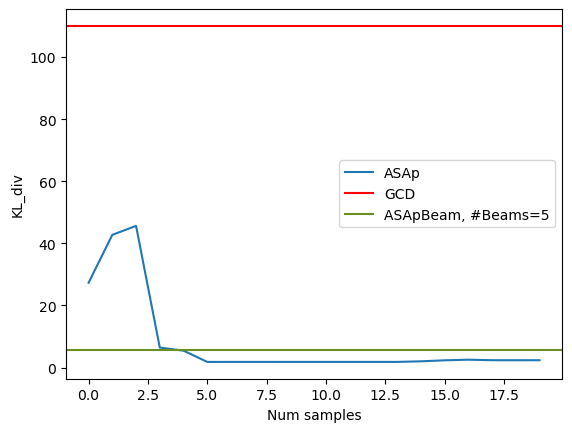

In [36]:
grammar_str = """ 

            start: "0\t0\t0\t0\t0\t" | "1\t" a 
            a: "0\t" b | "1\t" b
            b: "0\t" c | "1\t" c
            c: "0\t" d | "1\t" d
            d: "0\t" | "1\t" 
"""

grammar_str = """ 
            start: "0x0x0x0x0" | "1x" a 
            a: "0x" b | "1x" b
            b: "0x" c | "1x" c
            c: "0x" d | "1x" d
            d: "0" | "1" 
"""

bin_grammar = Grammar(grammar_str)

prompt = "Q: Generate a binary string with digits separated by 'x' that ends in 1. \nA:"

samples, EFG_tree, KL_divs = ASAp_test_bench(model, prompt, bin_grammar, tokenizer, num_samples=20, num_KL_div_samples=20, max_length=100)
# samples, EFG_tree, KL_divs = ASAp_test_bench(model, prompt, bin_grammar, tokenizer, num_samples=5, num_KL_div_samples=5, max_length=100)
display_test_bench_results(samples, KL_divs)

Generating KL_div samples..


  0%|          | 0/20 [00:00<?, ?it/s]

No accept tokens err count: 3
No accept tokens err count: 3
No accept tokens err count: 3
No accept tokens err count: 3
No accept tokens err count: 3
No accept tokens err count: 12
No accept tokens err count: 3
No accept tokens err count: 3
No accept tokens err count: 3
No accept tokens err count: 4
No accept tokens err count: 3
No accept tokens err count: 3
No accept tokens err count: 3
No accept tokens err count: 2
No accept tokens err count: 3
No accept tokens err count: 4
No accept tokens err count: 2
{1: tensor(15.2182, device='cuda:0'),
 2: tensor(64.0431, device='cuda:0'),
 5: tensor(12.8671, device='cuda:0'),
 8: tensor(14.7244, device='cuda:0'),
 10: tensor(15.1320, device='cuda:0')}


<Figure size 640x480 with 0 Axes>

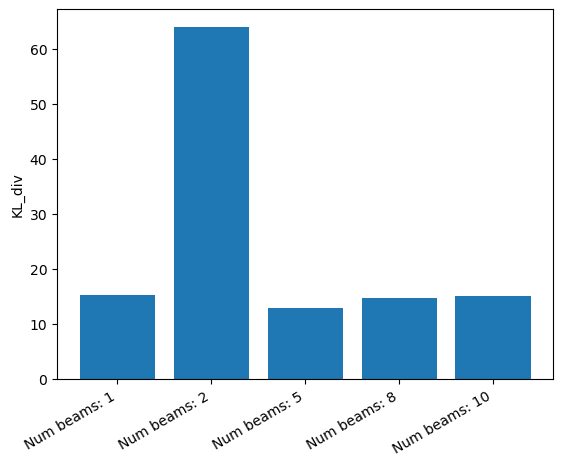

In [48]:
grammar_str = """ 

            start: "0\t0\t0\t0\t0\t" | "1\t" a 
            a: "0\t" b | "1\t" b
            b: "0\t" c | "1\t" c
            c: "0\t" d | "1\t" d
            d: "0\t" | "1\t" 
"""

grammar_str = """ 
            start: "0x0x0x0x0" | "1x" a 
            a: "0x" b | "1x" b
            b: "0x" c | "1x" c
            c: "0x" d | "1x" d
            d: "0" | "1" 
"""

bin_grammar = Grammar(grammar_str)

prompt = "Q: Generate a binary string with digits separated by 'x' that ends in 1. \nA:"
KL_divs = ASAp_Beam_test_bench(model, prompt, bin_grammar, tokenizer, max_length=100, num_KL_div_samples=20)
display_Beam_test_bench_results(KL_divs)

## JSON

Generating KL_div samples..


  0%|          | 0/100 [00:00<?, ?it/s]

Starting KL_div: 0.02272084727883339
Running ASAp..


  0%|          | 0/200 [00:00<?, ?it/s]

KL_div after sample 0: 0.02250204235315323
KL_div after sample 1: 0.028227845206856728
KL_div after sample 2: 0.02841910906136036
KL_div after sample 3: 0.03308390825986862
KL_div after sample 4: 0.040796227753162384
KL_div after sample 5: 0.02668316289782524
KL_div after sample 6: 0.02945180982351303
KL_div after sample 7: 0.03087184950709343
KL_div after sample 8: 0.03570957109332085
KL_div after sample 9: 0.04733903333544731
KL_div after sample 10: 0.04781476780772209
KL_div after sample 11: 0.04822873696684837
KL_div after sample 12: 0.048860423266887665
KL_div after sample 13: 0.027662504464387894
KL_div after sample 14: 0.030735911801457405
KL_div after sample 15: 0.03363151103258133
KL_div after sample 16: 0.02641993761062622
KL_div after sample 17: 0.03153308108448982
KL_div after sample 18: 0.03163265436887741
KL_div after sample 19: 0.034800898283720016
KL_div after sample 20: 0.03584504500031471
KL_div after sample 21: 0.0009677035268396139
KL_div after sample 22: 0.00104485

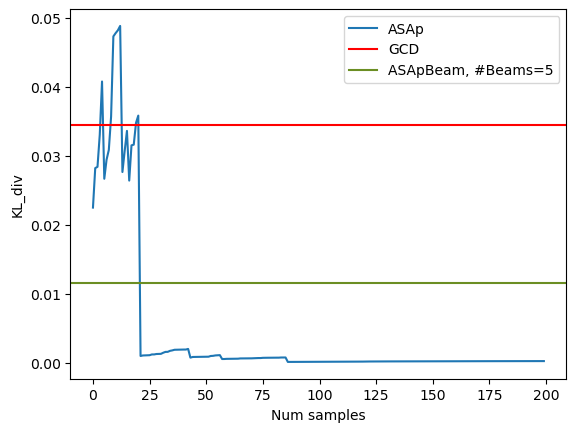

In [9]:
## Run testbench
prompt = "Q: Please return a json object to represent country India with name, capital and population. \nA:"
samples, EFG_tree, KL_divs = ASAp_test_bench(model, prompt, Grammar('json'), tokenizer, num_samples=200, num_KL_div_samples=100)
display_test_bench_results(samples, KL_divs)

Generating KL_div samples..


  0%|          | 0/100 [00:00<?, ?it/s]

{1: tensor(0.2215, device='cuda:0'),
 2: tensor(0.2793, device='cuda:0'),
 5: tensor(0.1897, device='cuda:0'),
 8: tensor(0.1966, device='cuda:0'),
 10: tensor(0.1065, device='cuda:0')}


<Figure size 640x480 with 0 Axes>

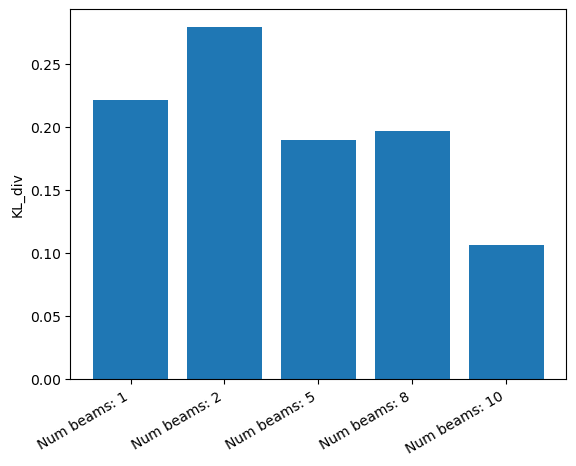

In [49]:
prompt = "Q: Please return a json object to represent country India with name, capital and population. \nA:"
KL_divs = ASAp_Beam_test_bench(model, prompt, Grammar('json'), tokenizer, num_KL_div_samples=100)
display_Beam_test_bench_results(KL_divs)

In [17]:
# For timing purposes
prompt = "Q: Please return a json object to represent country India with name, capital and population. \nA:"
asap_syncode_logits_processor = ASApSyncodeLogitsProcessor(grammar=Grammar('json'), tokenizer=tokenizer, parse_output_only=True, mode="grammar_strict")
ASAp(model, prompt, tokenizer, asap_syncode_logits_processor, max_length=100, num_samples=200)

  0%|          | 0/200 [00:00<?, ?it/s]

([{'output_ids': tensor([   48,    25,  4222,  1441,   257, 33918,  2134,   284,  2380,  1499,
            3794,   351,  1438,    11,  3139,   290,  3265,    13,   220,   198,
              32,    25,  1391,   198,   220,   366, 19315,  5376,     1,  1058,
             366, 21569,     1,   837,   198,   220,   366, 19315, 39315,     1,
            1058,   366,  3791, 12517,     1,   837,   198,   220,   366, 19315,
           45251,     1,  1058, 21503,  1314,  2388,   198,    92,   198,   198,
             201,   198,   201,   198,   201,   198,   201,   198,   201,   198,
             201,   198,   201,   198,   201,   198,   220,   628,   220,   198,
             201,   198,   220,   628,   220,   198,   198,   201,   198,   220,
             628,   220,   198,   198,   201,   198,   220,   628,   220,   198],
          device='cuda:0')},
  {'output_ids': tensor([   48,    25,  4222,  1441,   257, 33918,  2134,   284,  2380,  1499,
            3794,   351,  1438,    11,  3139,   290

In [18]:
%%time
syncode_logits_processor = ASApBeamSyncodeLogitsProcessor(grammar=Grammar('json'), tokenizer=tokenizer, parse_output_only=True, mode="grammar_strict")
result, EFG_tree = ASApBeam(model, prompt, tokenizer, syncode_logits_processor, num_beams = 5, add_out = False) 

CPU times: user 21.5 s, sys: 2.95 s, total: 24.4 s
Wall time: 22 s


## HumanEval

In [8]:
import json
human_eval = []
with open("/home/orange/syncode/human-eval/data/HumanEval.jsonl") as f:
    for line in f:
        human_eval.append(json.loads(line))
grammar = Grammar('python')
example = """
def return1() -> int:
    \"\"\" Returns the number 1.
    >>> return1()
    1
    \"\"\"
    return 1
    
"""
    
results = []

def test_on_i(i, results):
    prompt = example + human_eval[i]["prompt"]
    print(f"===\nPrompt: {prompt}=====")
    prompt_length = len(tokenizer(prompt, return_tensors='pt').input_ids[0])
    samples, EFG_tree, KL_divs = ASAp_test_bench(model, prompt, grammar, tokenizer, num_samples=100, num_KL_div_samples=250, max_length=50+prompt_length)
    # samples, EFG_tree, KL_divs = ASAp_test_bench(model, prompt, grammar, tokenizer, num_samples=75, num_KL_div_samples=200, max_length=100+prompt_length)
    display_test_bench_results(samples, KL_divs)


===
Prompt: 
def return1() -> int:
    """ Returns the number 1.
    >>> return1()
    1
    """
    return 1
    
from typing import List


def has_close_elements(numbers: List[float], threshold: float) -> bool:
    """ Check if in given list of numbers, are any two numbers closer to each other than
    given threshold.
    >>> has_close_elements([1.0, 2.0, 3.0], 0.5)
    False
    >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0, 2.0], 0.3)
    True
    """
=====
Generating KL_div samples..


  0%|          | 0/250 [00:00<?, ?it/s]

No accept tokens err count: 1
No accept tokens err count: 3
No accept tokens err count: 1
No accept tokens err count: 32
No accept tokens err count: 2
No accept tokens err count: 37
No accept tokens err count: 36
No accept tokens err count: 36
No accept tokens err count: 36
No accept tokens err count: 1
No accept tokens err count: 40
No accept tokens err count: 3
No accept tokens err count: 1
No accept tokens err count: 1
No accept tokens err count: 41
No accept tokens err count: 1
No accept tokens err count: 16
No accept tokens err count: 1
No accept tokens err count: 42
No accept tokens err count: 2
No accept tokens err count: 3
No accept tokens err count: 40
Starting KL_div: 0.3349559009075165
Running ASAp..


  0%|          | 0/100 [00:00<?, ?it/s]

KL_div after sample 0: 0.33547982573509216
KL_div after sample 1: 0.33618712425231934
KL_div after sample 2: 0.34070757031440735
KL_div after sample 3: 0.34070929884910583
KL_div after sample 4: 0.34126660227775574
KL_div after sample 5: 0.21463938057422638
KL_div after sample 6: 0.21463973820209503
KL_div after sample 7: 0.21801108121871948
KL_div after sample 8: 0.2182164490222931
KL_div after sample 9: 0.21821773052215576
KL_div after sample 10: 0.21835844218730927
KL_div after sample 11: 0.218466654419899
KL_div after sample 12: 0.2186044156551361
KL_div after sample 13: 0.21340171992778778
KL_div after sample 14: 0.21354082226753235
KL_div after sample 15: 0.21354225277900696
KL_div after sample 16: 0.2136136293411255
KL_div after sample 17: 0.18721407651901245
KL_div after sample 18: 0.18722330033779144
KL_div after sample 19: 0.18828046321868896
KL_div after sample 20: 0.18833184242248535
KL_div after sample 21: 0.1883334517478943
KL_div after sample 22: 0.1884487122297287
KL_di

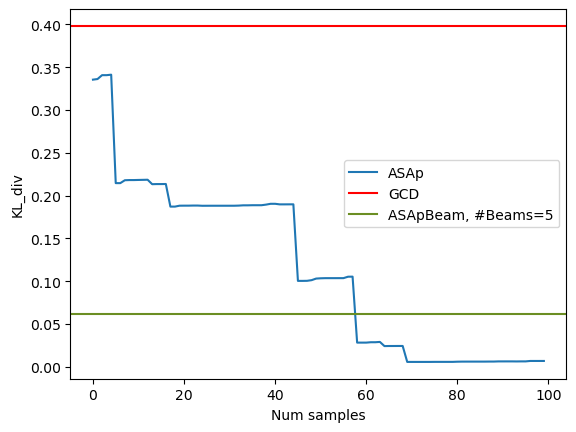

In [16]:
test_on_i(0,results)

Generating KL_div samples..


  0%|          | 0/100 [00:00<?, ?it/s]

No accept tokens err count: 3
No accept tokens err count: 39
No accept tokens err count: 97
No accept tokens err count: 160
No accept tokens err count: 1
No accept tokens err count: 1
{1: tensor(0.0540, device='cuda:0'),
 2: tensor(0.0625, device='cuda:0'),
 5: tensor(0.0715, device='cuda:0'),
 8: tensor(0.0198, device='cuda:0'),
 10: tensor(0.0102, device='cuda:0')}


<Figure size 640x480 with 0 Axes>

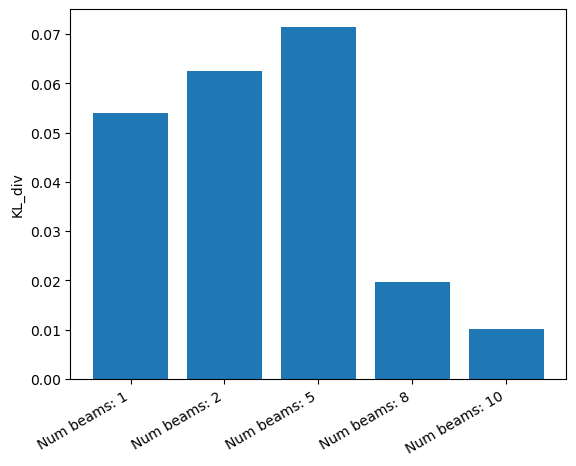

In [10]:
grammar = Grammar('python')
example = """
def return1() -> int:
    \"\"\" Returns the number 1.
    >>> return1()
    1
    \"\"\"
    return 1
    
"""
prompt = example + human_eval[0]["prompt"]
prompt_length = len(tokenizer(prompt, return_tensors='pt').input_ids[0])
KL_divs = ASAp_Beam_test_bench(model, prompt, grammar, tokenizer, num_KL_div_samples=100, max_length=50+prompt_length)
# samples, EFG_tree, KL_divs = ASAp_test_bench(model, prompt, grammar, tokenizer, num_samples=75, num_KL_div_samples=200, max_length=100+prompt_length)
display_Beam_test_bench_results(KL_divs)

In [19]:
# For timing purposes
asap_syncode_logits_processor = ASApSyncodeLogitsProcessor(grammar=Grammar('python'), tokenizer=tokenizer, parse_output_only=True, mode="grammar_strict")
prompt = example + human_eval[0]["prompt"]
print(f"===\nPrompt: {prompt}=====")
prompt_length = len(tokenizer(prompt, return_tensors='pt').input_ids[0])
ASAp(model, prompt, tokenizer, asap_syncode_logits_processor, max_length=50+prompt_length, num_samples=100)

===
Prompt: 
def return1() -> int:
    """ Returns the number 1.
    >>> return1()
    1
    """
    return 1
    
from typing import List


def has_close_elements(numbers: List[float], threshold: float) -> bool:
    """ Check if in given list of numbers, are any two numbers closer to each other than
    given threshold.
    >>> has_close_elements([1.0, 2.0, 3.0], 0.5)
    False
    >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0, 2.0], 0.3)
    True
    """
=====


  0%|          | 0/100 [00:00<?, ?it/s]

No accept tokens err count: 37
No accept tokens err count: 40
No accept tokens err count: 13
No accept tokens err count: 1
No accept tokens err count: 4
No accept tokens err count: 1
No accept tokens err count: 36
No accept tokens err count: 39
No accept tokens err count: 2
No accept tokens err count: 31
No accept tokens err count: 1
No accept tokens err count: 43


([{'output_ids': tensor([  198,  4299,  1441,    16,  3419,  4613,   493,    25,   198, 50284,
           37811, 16409,   262,  1271,   352,    13,   198, 50284, 33409,  1441,
              16,  3419,   198, 50284,    16,   198, 50284, 37811,   198, 50284,
            7783,   352,   198, 50284,   198,  6738, 19720,  1330,  7343,   628,
             198,  4299,   468,    62, 19836,    62,    68,  3639,     7,    77,
           17024,    25,  7343,    58, 22468,  4357, 11387,    25, 12178,     8,
            4613, 20512,    25,   198, 50284, 37811,  6822,   611,   287,  1813,
            1351,   286,  3146,    11,   389,   597,   734,  3146,  5699,   284,
            1123,   584,   621,   198, 50284, 35569, 11387,    13,   198, 50284,
           33409,   468,    62, 19836,    62,    68,  3639, 26933,    16,    13,
              15,    11,   362,    13,    15,    11,   513,    13,    15,  4357,
             657,    13,    20,     8,   198, 50284, 25101,   198, 50284, 33409,
             4

In [21]:
%%time
syncode_logits_processor = ASApBeamSyncodeLogitsProcessor(grammar=Grammar('python'), tokenizer=tokenizer, parse_output_only=True, mode="grammar_strict")
result, EFG_tree = ASApBeam(model, prompt, tokenizer, syncode_logits_processor, num_beams = 5, add_out = False, max_length=50+prompt_length) 

No accept tokens err count: 97
CPU times: user 20.7 s, sys: 5.39 s, total: 26.1 s
Wall time: 22.3 s
